In [46]:
import numpy as np
import pickle as pkl
import time
import json
import random
import torch
from torch import nn
import editdistance
import os
np.seterr(divide='ignore') # masks log(0) errors

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [47]:
from rnn.loader import make_loader, Preprocessor
from rnn.model import Seq2Seq
from rnn.model import LinearND #Hint: this is useful when defining the modified attention mechanism

In [48]:
from itertools import product
import matplotlib.pyplot as plt

With the default config, you can get 10-15% dev WER within 20 epochs. Each epoch will take 5 secs on a GPU and 10 secs on CPU

In [37]:
class Attention(nn.Module):
    def __init__(self, enc_dim, dec_dim, attn_dim=None):
        """
        Initialize Attention.
        ----
        enc_dim: encoder hidden state dimension
        dec_dim: decoder hidden state dimension
        attn_dim: attention feature dimension
        """
        super(Attention, self).__init__()
        if enc_dim == dec_dim and attn_dim is None:
            self.use_default = True
        elif attn_dim is not None:
            self.use_default = False
            self.attn_dim = attn_dim
            self.enc_dim = enc_dim
            self.dec_dim = dec_dim
            self.v = LinearND(self.attn_dim, 1, bias=False)
            self.W1 = LinearND(self.enc_dim, self.attn_dim, bias=False)
            self.W2 = nn.Linear(self.dec_dim, self.attn_dim, bias=False)
        else:
            raise ValueError("invalid args (enc_dim={}, dec_dim={}, attn_dim={})".format(enc_dim, dec_dim, attn_dim))

    def forward(self, eh, dhx, ax=None):
        """
        Forward Attention method.
        ----
        eh (FloatTensor): the encoder hidden state with
            shape (batch size, time, hidden dimension).
        dhx (FloatTensor): one time step of the decoder hidden
            state with shape (batch size, hidden dimension).
        ax (FloatTensor): one time step of the attention vector.
        ----
        Returns the context vectors (sx) and the corresponding attention alignment (ax)
        """
        
        if self.use_default:
            # Compute inner product of decoder slice with every encoder slice
            pax = torch.sum(eh * dhx, dim=2)
            ax = nn.functional.softmax(pax, dim=1)
            sx = torch.sum(eh * ax.unsqueeze(2), dim=1, keepdim=True)
        else:
            # TODO: Modify the attention mechanism
            pax = torch.empty(dhx.shape)
            pax = self.v.forward(torch.tanh(self.W1.forward(eh) + self.W2.forward(dhx)))
            ax = nn.functional.softmax(pax, dim=1).squeeze()
            sx = torch.sum(eh * ax.unsqueeze(2), dim=1, keepdim=True)

        return sx, ax

In [8]:
def compute_wer(results):
    """
    Compute the word-error-rate (WER).
    """
    dist = 0.
    for label, pred in results:
        dist += editdistance.eval(label, pred)
    total = sum(len(label) for label, _ in results)
    return dist / total

def train(model, optimizer, ldr):
    """
    Train the model for an epoch (one pass over the training data)
    ----
    model: Seq2Seq model instance
    optimizer: torch.nn optimizer instance
    ldr: data loader instance
    ----
    Returns the average loss over an epoch
    """
    model.train()
    model.scheduled_sampling = model.sample_prob != 0
    
    losses = []
    
    for ii, (inputs, labels) in enumerate(ldr):
        optimizer.zero_grad()
        x, y = model.collate(inputs, labels)
        loss = model.loss(x, y)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        losses.append(loss.data.item())
        
    return np.mean(losses)

def evaluate(model, ldr, preproc):
    """
    Evaluate the model (on either dev or test).
    ----
    model: Seq2Seq model instance
    ldr: data loader instance
    preproc: preprocessor instance
    ----
    Returns the average loss and wer on a given dataset
    """
    model.eval()
    model.scheduled_sampling = False
    
    losses, hyps, refs = [], [], []
    
    with torch.no_grad():
        for inputs, labels in ldr:
            x, y = model.collate(inputs, labels)
            # get loss
            loss = model.loss(x, y)
            losses.append(loss.data.item())
            # get predictions
            pred = model.infer(x, y)
            hyps.extend(pred)
            refs.extend(labels)

    results = [(preproc.decode(r), preproc.decode(h)) for r, h in zip(refs, hyps)]
    
    return np.mean(losses), compute_wer(results)

In [43]:
# TODO: tune on the dev set
# may want to set up function or chunk of code here to perform tuning
# call train on training set, call evaluate on dev, save/plot/compare results
def tune(hyperparams):
    """hyperparams is a dict"""
    with open("rnn/config.json", "r") as fid:                                                                                                                                                                                                                                      
        config = json.load(fid)

    random.seed(config["seed"])
    np.random.seed(config["seed"])
    torch.manual_seed(config["seed"])

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        torch.backends.cudnn.deterministic = True

    data_cfg = config["data"]
    model_cfg = config["model"]
    opt_cfg = config["optimizer"]
    # fill in params, override config default if params are provided in the function
    attention_dim = hyperparams.get('attention_dim', None)
    batch_size = hyperparams.get('batch_size', opt_cfg["batch_size"])
    learning_rate = hyperparams.get('learning_rate', opt_cfg["learning_rate"])
    enc_hidden_size = hyperparams.get('enc_hidden_size', model_cfg["encoder"]["hidden_size"])
    dec_hidden_size = hyperparams.get('dec_hidden_size', model_cfg["decoder"]["hidden_size"])
    max_epochs = hyperparams.get('max_epochs', opt_cfg["max_epochs"])
    
    preproc = Preprocessor(data_cfg["train_set"], start_and_end=data_cfg["start_and_end"])

    train_ldr = make_loader(data_cfg["train_set"], preproc, batch_size)
    dev_ldr = make_loader(data_cfg["dev_set"], preproc, batch_size)
    
    attention = Attention(enc_hidden_size, dec_hidden_size, attention_dim)
    model = Seq2Seq(preproc.input_dim, preproc.vocab_size, attention, model_cfg)
    model = model.cuda() if use_cuda else model.cpu()
    # sampling prob
    model.sample_prob = hyperparams.get('sample_prob', config['model']['sample_prob'])
    meta = '+'.join([str(elm) for elm in [attention_dim, batch_size, learning_rate, enc_hidden_size, 
                     dec_hidden_size, max_epochs, np.round(model.sample_prob, 2)]])
    print('Model Configuration (att, batch, lr, enc_hid, dec_hid, ep, sp):', meta)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=opt_cfg["momentum"])

    log="epoch {:4} | train_loss={:6.2f}, dev_loss={:6.2f} with {:6.2f}% WER ({:6.2f}s elapsed)"
    print("Training RNN")
    best_so_far = float("inf")
    
    plotting = {'WER': [], 'train_loss': [], 'dev_loss': []}
    for ep in range(max_epochs):
        start = time.time()

        train_loss = train(model, optimizer, train_ldr)    
        dev_loss, dev_wer = evaluate(model, dev_ldr, preproc)
        
        plotting['WER'].append(dev_wer)
        plotting['train_loss'].append(train_loss)
        plotting['dev_loss'].append(dev_loss)
        print(log.format(ep + 1, train_loss, dev_loss, dev_wer * 100., time.time() - start))

        torch.save(model, os.path.join(config["save_path"], str(ep)))

        if dev_wer < best_so_far:
            best_so_far = dev_wer
            best = 'best-' + meta
            torch.save(model, os.path.join(config["save_path"], best))
    return best, plotting

In [39]:
def plot_wer_loss(best, plotting):
    plt.suptitle(best)
    plt.subplot(1, 2, 1)
    plt.plot(plotting['WER'], label='WER')
    plt.legend()
    plt.xlabel('# epochs')
    plt.ylabel('WER')
    plt.subplot(1, 2, 2)
    plt.plot(plotting['dev_loss'], label='dev_loss')
    plt.plot(plotting['train_loss'], label='train_loss')
    plt.legend()
    plt.xlabel('# epochs')
    plt.ylabel('loss')
    plt.savefig('figures/' + best + '.png')
    plt.show()

## (e) i. Loss and WER

Model Configuration (att, batch, lr, enc_hid, dec_hid, ep, sp): None+10+1+16+16+5+0.9
Training RNN
epoch    1 | train_loss=  5.25, dev_loss=  5.47 with  83.04% WER (  8.15s elapsed)
epoch    2 | train_loss=  4.24, dev_loss=  3.93 with  68.93% WER (  8.38s elapsed)
epoch    3 | train_loss=  3.61, dev_loss=  3.33 with  63.21% WER ( 12.28s elapsed)
epoch    4 | train_loss=  3.13, dev_loss=  3.02 with  57.50% WER ( 11.85s elapsed)
epoch    5 | train_loss=  2.80, dev_loss=  3.60 with  60.71% WER (  9.25s elapsed)


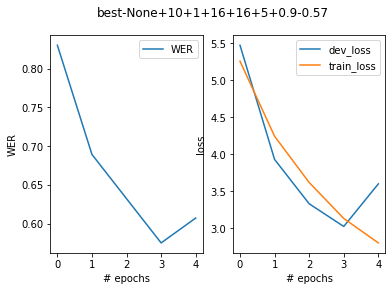

In [40]:
best, plotting = tune({})
plot_wer_loss(best, plotting)

Model Configuration (att, batch, lr, enc_hid, dec_hid, ep, sp): 8+10+1+16+16+5+0.9
Training RNN


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch    1 | train_loss=  5.71, dev_loss=  5.03 with  80.54% WER (  9.36s elapsed)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


epoch    2 | train_loss=  4.08, dev_loss=  3.81 with  71.07% WER (  9.73s elapsed)
epoch    3 | train_loss=  3.50, dev_loss=  3.24 with  61.61% WER (  9.67s elapsed)
epoch    4 | train_loss=  3.10, dev_loss=  3.06 with  60.00% WER (  9.84s elapsed)
epoch    5 | train_loss=  2.96, dev_loss=  3.09 with  58.93% WER (  9.13s elapsed)


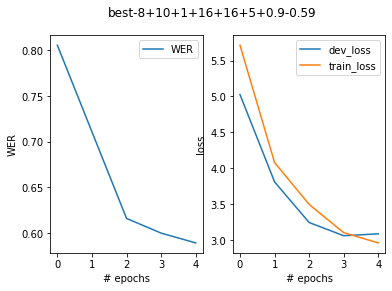

In [41]:
best, plotting = tune({})
plot_wer_loss(best, plotting)

## (e) ii. Sampling Prob

Model Configuration (att, batch, lr, enc_hid, dec_hid, ep, sp): None+10+1+16+16+1+0.1
Training RNN


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch    1 | train_loss=  5.22, dev_loss=  4.23 with  75.89% WER (  8.52s elapsed)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


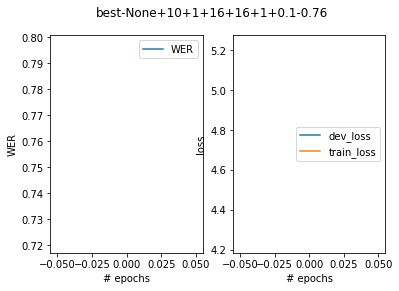

Model Configuration (att, batch, lr, enc_hid, dec_hid, ep, sp): None+10+1+16+16+1+0.3
Training RNN


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch    1 | train_loss=  5.21, dev_loss=  4.25 with  77.86% WER (  8.61s elapsed)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


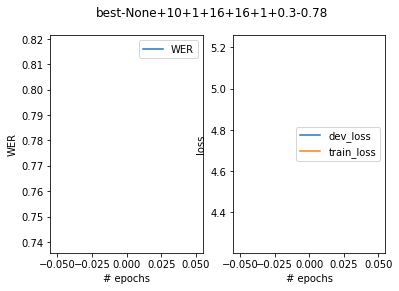

KeyboardInterrupt: 

In [75]:
# for sp in np.arange(0.1, 1, 0.2):
#     hp = {'sample_prob': sp, 'max_epochs': 20}
#     best, plotting = tune(hp) 
#     plot_wer_loss(best, plotting)

In [40]:
# naive grid search through different parameters
# atts = [None, 4, 8]
# bs = [10, 100]
# lrs = [0.5, 1, 5, 10]
# encs = [16, 32]
# decs = [16, 32]
# max_epochs = [20]
# for params in product(atts, bs, lrs, encs, decs, max_epochs):
#     hp = {}
#     hp['attention_dim'] = params[0]
#     hp['batch_size'] = params[1]
#     hp['learning_rate'] = params[2]
#     hp['enc_hidden_size'] = params[3]
#     hp['dec_hidden_size'] = params[4]
#     hp['max_epochs'] = params[5]
#     tune(hp)

Model Configuration (att, batch, lr, enc_hid, dec_hid, ep): 4+10+0.5+16+16+1
Model Configuration (att, batch, lr, enc_hid, dec_hid, ep): 4+10+0.5+16+32+1
Model Configuration (att, batch, lr, enc_hid, dec_hid, ep): 4+10+0.5+32+16+1
Model Configuration (att, batch, lr, enc_hid, dec_hid, ep): 4+10+0.5+32+32+1
Model Configuration (att, batch, lr, enc_hid, dec_hid, ep): 4+10+1+16+16+1
Model Configuration (att, batch, lr, enc_hid, dec_hid, ep): 4+10+1+16+32+1
Model Configuration (att, batch, lr, enc_hid, dec_hid, ep): 4+10+1+32+16+1
Model Configuration (att, batch, lr, enc_hid, dec_hid, ep): 4+10+1+32+32+1
Model Configuration (att, batch, lr, enc_hid, dec_hid, ep): 4+10+5+16+16+1
Model Configuration (att, batch, lr, enc_hid, dec_hid, ep): 4+10+5+16+32+1
Model Configuration (att, batch, lr, enc_hid, dec_hid, ep): 4+10+5+32+16+1
Model Configuration (att, batch, lr, enc_hid, dec_hid, ep): 4+10+5+32+32+1
Model Configuration (att, batch, lr, enc_hid, dec_hid, ep): 4+10+10+16+16+1
Model Configurat

In [53]:
def test(best):
    print("Testing RNN")
    with open("rnn/config.json", "r") as fid:                                                                                                                                                                                                                                      
        config = json.load(fid)
    data_cfg = config["data"]
    opt_cfg = config["optimizer"]
    test_model = torch.load(os.path.join(config["save_path"], best))
    preproc = Preprocessor(data_cfg["train_set"], start_and_end=data_cfg["start_and_end"])
    test_ldr = make_loader(data_cfg["test_set"], preproc, opt_cfg["batch_size"])

    _, test_wer = evaluate(test_model, test_ldr, preproc)

    print("{:.2f}% WER (test)".format(test_wer * 100.))